## Transfer learning with TF part 1 : Feature extraction 

Transfer learning is leveraging a working model's existing architecture and learned patterns for our problem. 

Benefits:

1.Can leverage a working NN to our own problem. 

2.Can leverage learned patterns to our own data.

In [6]:
#Get the data 

import zipfile
#Download 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


--2021-11-03 12:34:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolvendo storage.googleapis.com (storage.googleapis.com)... 172.217.17.16, 142.250.178.176, 142.250.184.16, ...
Conectando con storage.googleapis.com (storage.googleapis.com)|172.217.17.16|:443... conectado.
Petición HTTP enviada, agardando unha resposta... 200 OK
Lonxitude: 168546183 (161M) [application/zip]
Gardando en: «10_food_classes_10_percent.zip»

10_food_classes_10_ 100%[===================>] 160,74M  13,4MB/s    in 15s     

2021-11-03 12:34:20 (11,0 MB/s) - gardouse «10_food_classes_10_percent.zip» [168546183/168546183]



In [7]:
#Unzip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip","r")
zip_ref.extractall()
zip_ref.close()

In [9]:
#How many images in each folder ? 

import os 

for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [12]:
#Creating data loaders (preparing the data)

from tensorflow.keras. preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale =1/255.)
test_datagen = ImageDataGenerator(rescale =1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir, 
                                                          target_size = IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode = "categorical")
test_data = test_datagen.flow_from_directory(test_dir, 
                                                          target_size = IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode = "categorical")

Training images:
Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run while the model trains)
Call backs are extra functionarlity that you add to your models to be performed during or after training. Examples:
*Tracking experiments
*Model checkpoints 
*Stop a model from training if reaches a condition

In [50]:
#Create TensorBoard callback (funtionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name +"/" + experiment_name + "/" +datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

## Creating models using TensorFlow Hub

In [67]:
##Comparar dos modelos

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [52]:
#Import dependencies

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [53]:
#Let's make a create_mode function to create a model from URL

def create_model (model_url,num_classes=10):
    """Takes a Tf hub url and create a keras sequential model
    Args:
    model_url(str): A TFHub feature extraction URL,
    num_classes(int): Nuum of output neurons in the output layer.
    Returns: 
    An uncompliled keras sequential model with model_url as feature extractor layer
    """
    #Download the pretrained model and save it as a keras layers
    feature_extraction_layer = hub.KerasLayer(model_url,trainable=False,
                                            name = "feature_extraction_layer",
                                            input_shape = IMG_SHAPE+(3,))#freeze the already learned patterns
    #Create our own model 
    model = tf.keras.Sequential([
        feature_extraction_layer,
        layers.Dense(num_classes,activation="softmax",name = "output_layer")
    ])
    return model

In [54]:
#Create Resnet model 
resnet_model = create_model(resnet_url,num_classes = train_data_10_percent.num_classes)

In [55]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [56]:
#Compila the resnet model 
resnet_model.compile(loss="categorical_crossentropy",
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

In [57]:
history_resnet = resnet_model.fit(train_data_10_percent,
                       epochs=5,
                       callbacks = create_tensorboard_callback("prueba","1"),
                       steps_per_epoch=len(train_data_10_percent),
                       validation_data=test_data,
                       validation_steps=(len(test_data)))

Saving TensorBoard log files to: prueba/1/20211103-174846
Epoch 1/5
24/24 [==============================] - 161s 7s/step - loss: 1.8069 - accuracy: 0.3947 - val_loss: 1.1320 - val_accuracy: 0.6492
Epoch 2/5
24/24 [==============================] - 161s 7s/step - loss: 0.8972 - accuracy: 0.7280 - val_loss: 0.8172 - val_accuracy: 0.7400
Epoch 3/5
24/24 [==============================] - 159s 7s/step - loss: 0.6267 - accuracy: 0.8307 - val_loss: 0.7304 - val_accuracy: 0.7708
Epoch 4/5
24/24 [==============================] - 159s 7s/step - loss: 0.4922 - accuracy: 0.8640 - val_loss: 0.6973 - val_accuracy: 0.7728
Epoch 5/5
24/24 [==============================] - 160s 7s/step - loss: 0.3900 - accuracy: 0.8880 - val_loss: 0.6693 - val_accuracy: 0.7804


In [65]:
#Let's create a function to plot the loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Return separate loss curves for training and validation
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    plt.plot(epochs,loss,label="training_loss")
    plt.plot(epochs,val_loss,label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    
    plt.figure()
    plt.plot(epochs,accuracy,label="training_accuracy")
    plt.plot(epochs,val_accuracy,label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    

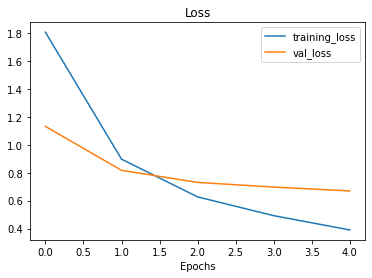

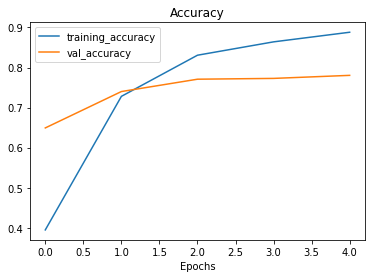

In [66]:
plot_loss_curves(history_resnet)

## Creating and testing EfficientNetB0 TFHub

In [75]:
#Create efficient model 
efficient_model = create_model(efficientnet_url,num_classes = train_data_10_percent.num_classes)

In [76]:
efficient_model.compile(loss="categorical_crossentropy",
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=["accuracy"])

In [78]:
efficient_history = efficient_model.fit(train_data_10_percent,
                                        epochs=5,
                                        callbacks=create_tensorboard_callback("prueba","2"),
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data = test_data,
                                        validation_steps = len(test_data))

Saving TensorBoard log files to: prueba/2/20211103-182113
Epoch 1/5
24/24 [==============================] - 79s 3s/step - loss: 1.7917 - accuracy: 0.4813 - val_loss: 1.2732 - val_accuracy: 0.7260
Epoch 2/5
24/24 [==============================] - 74s 3s/step - loss: 1.0508 - accuracy: 0.7760 - val_loss: 0.8591 - val_accuracy: 0.8224
Epoch 3/5
24/24 [==============================] - 74s 3s/step - loss: 0.7553 - accuracy: 0.8280 - val_loss: 0.6951 - val_accuracy: 0.8408
Epoch 4/5
24/24 [==============================] - 74s 3s/step - loss: 0.6099 - accuracy: 0.8693 - val_loss: 0.6091 - val_accuracy: 0.8532
Epoch 5/5
24/24 [==============================] - 75s 3s/step - loss: 0.5118 - accuracy: 0.8893 - val_loss: 0.5558 - val_accuracy: 0.8612


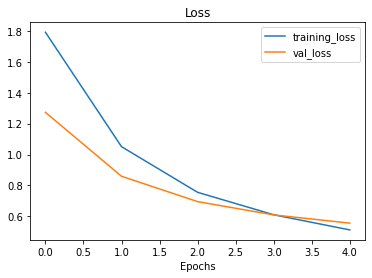

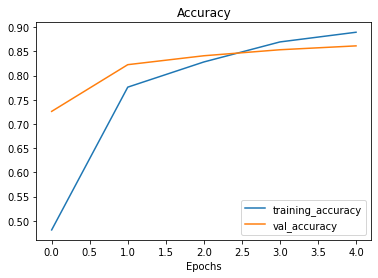

In [79]:
plot_loss_curves(efficient_history)

In [80]:
efficient_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [81]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Different types of transfer learning

* **"As is"  transfer learning**- using an existing model with no changes whatsoever (eg using Imagenet model on 100 Imagenet classes)

* Feature extraction, using the prelearned patterns, eg Efficient net trained on Imagenet and adjust the output layer 
* "fine-tuning transfer learning, using the prelearned patterns and fine tune many of all of the layers, including new ones 

In [85]:
len(efficient_model.layers[0].weights)

309

## Compare our model results using TensorBoard

In [111]:
!tensorboard dev upload --logdir ./logs/ \ 
--name "1vs2" \ 
--description "Comparing two TF hub feature extraction architectures" \
--one_shot

SyntaxError: invalid syntax (<ipython-input-111-df58e3fd7f11>, line 2)

In [110]:
import tensorflow as tf
import datetime,os
!tensorboard --logdir logs

2021-11-04 10:54:24.366514: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-04 10:54:24.366566: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.7.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


## Homework

In [123]:
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [124]:
mobilenet_model = create_model(mobilenet_url)
mobilenet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=["accuracy"])

In [126]:
train_data_10_percent_rescaled = tf.keras.layers.Rescal(1./127.5,offset=1)
test_data_rescaled = tf.keras.layers.Rescaling(1./127.5,offset=1)
mobilenet_history = mobilenet_model.fit(train_data_10_percent_rescaled,
                   epochs=5,
                   steps_per_epoch=len(train_data_10_percent_rescaled),
                   validation_data=test_data_rescaled,
                   validation_steps=len(test_data_rescaled))

AttributeError: module 'tensorflow.keras.layers' has no attribute 'Rescale'

In [122]:
train_data_10_percent.next()

(array([[[[0.09803922, 0.0509804 , 0.05882353],
          [0.11764707, 0.07058824, 0.07843138],
          [0.15294118, 0.10588236, 0.1137255 ],
          ...,
          [0.31764707, 0.18039216, 0.10588236],
          [0.3019608 , 0.1764706 , 0.11764707],
          [0.2627451 , 0.14901961, 0.09411766]],
 
         [[0.09019608, 0.04313726, 0.0509804 ],
          [0.08627451, 0.03921569, 0.04705883],
          [0.13333334, 0.08627451, 0.09411766],
          ...,
          [0.29803923, 0.16078432, 0.08627451],
          [0.3019608 , 0.1764706 , 0.11764707],
          [0.3372549 , 0.227451  , 0.17254902]],
 
         [[0.09411766, 0.05490196, 0.05882353],
          [0.08235294, 0.04313726, 0.04705883],
          [0.09803922, 0.05882353, 0.0627451 ],
          ...,
          [0.3803922 , 0.24313727, 0.16862746],
          [0.3529412 , 0.23137257, 0.16078432],
          [0.30980393, 0.19607845, 0.13333334]],
 
         ...,
 
         [[0.82745105, 0.5803922 , 0.2784314 ],
          [0.80000

In [128]:
tf.__version__

'2.5.0'